<a href="https://colab.research.google.com/github/thallescotta/fotonica-computacional-uff-2025-2/blob/main/FotonicaComputacional_BlocoA_TE1D_2025_09_13_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- Imagem alinhada à esquerda -->
<p align="left">
  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSHYOnIACPcb9bCeQQ_wbfF9mp5ADlbCIoghtDM6YiLklaBrtEsAxZ-G-y6N3_PNR_tCmw&usqp=CAU"
       alt="Logo CEFET"
       width="360">   <!-- tamanho da logo -->
</p>

# **Thalles Cotta Fontainha**  -  **PPGIO Matrícula: 2410091DIOAMA**

## *"Fotonica Analise Modal e BPM V2.pdf"* :
https://github.com/thallescotta/fotonica-computacional-uff-2025-2/blob/main/Fotonica%20Analise%20Modal%20e%20BPM%20V2.pdf
recebido em 11/09/2025

### **Disciplina**: Fotônica Computacional  
**Código da disciplina:** TCE11209 - [UFF]  
**Professor:** Andres Pablo Lopez Barbero

## Atividade 1 - Análise Modal (Guia Planar 1D, modos TE)

**Contexto:**  
Nesta primeira etapa estuda-se um **guia planar** em que tudo é igual nas direções **y** e **z**. Por isso, só olhamos como o campo muda ao longo de **x** — é isso que chamamos de **1D** (uma dimensão). Já **TE (Transversal Elétrico)** quer dizer que o campo elétrico é **transversal** à direção de propagação (**z**), ou seja, **não tem componente em z**.

**Objetivo:**  
Formular a equação de onda e resolver numericamente (diferenças finitas) o problema modal:

$$
\frac{d^2 E}{dx^2} + k_0^2\,n(x)^2\,E = \beta^2\,E
\quad\Longleftrightarrow\quad
\left[\frac{1}{k_0^2}\frac{d^2}{dx^2} + n(x)^2\right] E = n_{\mathrm{eff}}^2 E,\;\;
\beta = k_0 n_{\mathrm{eff}}
$$

**Pipeline:**  
1. **Pré-processamento** – define-se n(x), λ₀, a janela e a malha Δx.  
2. **Processamento**; [próxima etapa]
3. **Pós-processamento**; [próxima etapa]

**Caso do slide [pág. 15] :** n2 = 3.60, n1 = n3 = 3.55


In [1]:
# Instala Octave e a ponte Python→Octave
!apt-get -y install -qq octave gnuplot > /dev/null
!pip -q install oct2py
from oct2py import octave
octave.eval("graphics_toolkit gnuplot");  # backend headless para salvar figuras
print("Octave no ar!")

Extracting templates from packages: 100%
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.4 MB/s eta 0:00:00
Octave no ar!


## Guia de execução:

Seguindo escopo da disciplina e slide da atividade, além da orientação do professor, dividi a execução em três blocos:

*   **(Bloco A) Pré-processamento** (parâmetros, domínio/malha e perfil *n(x)* com camadas generalizadas),
*   **(Bloco B) Montagem matricial** (discretização e construção das matrizes do problema modal) e
*   **(Bloco C) Solução e análise** (autovalores/autovetores, seleção de modos e gráficos).

Nesta etapa, conforme o cronograma, será executado apenas o **Bloco A**. Para isso segue alguns dados deste bloco.


- **O que a célula acima faz? :** Prepara o ambiente para rodar **MATLAB via Octave** dentro do Colab (`octave` + `oct2py`) e ajusta o backend gráfico;

- **Linguagem adotada a partir da célula seguinte:** usei **Python (NumPy/Matplotlib)** para o **Bloco A**. A lógica é a mesma dos slides e pretende ser **equivalente ao MATLAB** (mesmos passos/variáveis). Essa escolha pretende agilizar testes e depuração no Google Colab;

- **O que será feito na célula abaixo? :** defini-se parâmetros físicos, domínio e malha, **criar generalização do número de camadas** (`layers`) e construir o perfil **n(x)** com gráfico e *prints* de conferência.

[INFO] lambda0 = 1.550e-06 m | k0 = 4.054e+06 1/m
[INFO] Nx = 1200 | dx = 3.336e-09 m | dominio = [-2.00e-06, 2.00e-06] m
[INFO] n_core = 3.6000 | n_clad_edges = 3.5500
[INFO] Camadas (N=3): [-2.00e-06,-2.50e-07]->n=3.550, [-2.50e-07,2.50e-07]->n=3.600, [2.50e-07,2.00e-06]->n=3.550


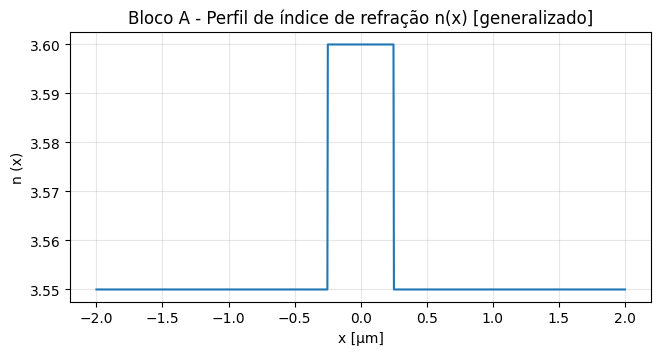

In [7]:
# =============================
# BLOCO A - PRÉ-PROCESSAMENTO (Python/Colab)
# Objetivo: definir parâmetros, malha e perfil n(x) GENERALIZADO (N camadas)
# =============================
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def info(msg: str):
    print(f"[INFO] {msg}")

# --- Parâmetros físicos ---
lambda0 = 1.55e-6   # [m]
k0 = 2*np.pi/lambda0

# --- Caso simétrico (pág. 15 do slide) como EXEMPLO padrão ---
n1, n2, n3 = 3.55, 3.60, 3.55  # n2 = núcleo; n1=n3 = cascas
w_core = 0.5e-6                # [m] largura do núcleo (ajustável)

# --- Malha/Janela ---
x_span = (-2.0e-6, 2.0e-6)     # [m]
Nx = 1200                      # nº de pontos
x = np.linspace(x_span[0], x_span[1], Nx)
dx = x[1] - x[0]

# --- Camadas GENERALIZADAS: lista de dicts [x_ini, x_fim, n] (adiciona-se quantas quiser) ---
x0, x1 = -w_core/2, w_core/2
layers = [
    {"x_ini": x_span[0], "x_fim": x0, "n": n1},  # cladding esquerdo
    {"x_ini": x0,         "x_fim": x1, "n": n2},  # núcleo
    {"x_ini": x1,         "x_fim": x_span[1], "n": n3},  # cladding direito
]
# Exemplo de mais camadas (comente/descomente e ajusta-se):
# layers = [
#     {"x_ini": x_span[0], "x_fim": -1.2e-6, "n": 3.40},
#     {"x_ini": -1.2e-6,   "x_fim": x0,      "n": 3.55},
#     {"x_ini": x0,        "x_fim": x1,      "n": 3.60},
#     {"x_ini": x1,        "x_fim": 1.2e-6,  "n": 3.55},
#     {"x_ini": 1.2e-6,    "x_fim": x_span[1], "n": 3.40},
# ]

def build_index_profile(x, layers):
    """Gera n(x) e n^2(x) para qualquer quantidade de camadas."""
    n = np.zeros_like(x)
    for L in layers:
        mask = (x >= L["x_ini"]) & (x < L["x_fim"])  # intervalo semifechado
        n[mask] = L["n"]
    n[-1] = layers[-1]["n"]  # garante o último ponto
    return n, n**2

n_profile, n2_profile = build_index_profile(x, layers)

# --- PRINTS do Bloco A ---
n_core = np.max(n_profile)
n_clad_edges = min(n_profile[0], n_profile[-1])
info(f"lambda0 = {lambda0:.3e} m | k0 = {k0:.3e} 1/m")
info(f"Nx = {Nx} | dx = {dx:.3e} m | dominio = [{x[0]:.2e}, {x[-1]:.2e}] m")
info(f"n_core = {n_core:.4f} | n_clad_edges = {n_clad_edges:.4f}")
info("Camadas (N=%d): %s" % (len(layers),
     ", ".join([f"[{L['x_ini']:.2e},{L['x_fim']:.2e}]->n={L['n']:.3f}" for L in layers])))

# --- PLOT ilustrativo do Bloco A ---
plt.figure(figsize=(7.5,3.5))
plt.plot(x*1e6, n_profile)
plt.xlabel('x [µm]'); plt.ylabel('n (x)')
plt.title('Bloco A - Perfil de índice de refração n(x) [generalizado]')
plt.grid(True, alpha=0.3)
plt.show()


# =============================
# BLOCO B — MONTAGEM MATRICIAL
# Montar, a partir da discretização, as matrizes do problema modal (operador e termos do meio),
# realizar checagens básicas e incluir visualizações auxiliares conforme a atividade.


# -----------------------------
# BLOCO C — SOLUÇÃO E ANÁLISE
# Resolver o problema modal (autovalores/autovetores) conforme a formulação dos slides,
# identificar os modos físicos, normalizar e apresentar gráficos ilustrativos dos resultados.
# =============================

## Referências:

1. Okamoto, K. — *Fundamentals of Optical Waveguides* (2ª ed., Academic Press, 2006).  
   PDF: [https://github.com/thallescotta/fotonica-computacional-uff-2025-2/blob/main/%5BKatsunari_Okamoto%5D_Fundamentals_of_optical_waveguide.pdf](https://github.com/thallescotta/fotonica-computacional-uff-2025-2/blob/main/%5BKatsunari_Okamoto%5D_Fundamentals_of_optical_waveguide.pdf)

2. **modesolverpy** — Photonic mode solver em **Python** (SciPy/Matplotlib), com diversos exemplos práticos de solução modal.  
   GitHub: [https://github.com/jtambasco/modesolverpy](https://github.com/jtambasco/modesolverpy)
